In [1]:
import logging
import os
import sys
import functools as ft
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
os.chdir('..')
import pp5
import pp5.parallel
from pp5.protein import ProteinRecord

In [3]:
os.chdir(pp5.PROJECT_DIR)
COLLECTOR_DIR = Path('out/pgroup-collected/20200510_173642-violeta-p32r18')
PDB_LIST_FILENAME = 'meta-structs_all.csv'

infile_path = COLLECTOR_DIR.joinpath(PDB_LIST_FILENAME)
df_pdb_ids = pd.read_csv(str(infile_path), index_col=None, header=0,
                         usecols=['unp_id', 'pdb_id'])
df_pdb_ids

,unp_id,pdb_id
0,A0A003,6KV9:A
1,A0A003,6KVC:A
2,A0A011,3VK5:A
3,A0A011,3VK5:B
4,A0A011,3VKA:A
...,...,...
53235,X5KSV5,6WNG:A
53236,X5KSV5,6WNG:B
53237,X5KSV5,6WNG:C
53238,X5KSV5,6WNG:D


In [4]:
unp_pdb_tuples = [(row.unp_id, row.pdb_id) for row in df_pdb_ids.itertuples()]


In [74]:
SS_TYPE_ANY = 'ANY'
SS_TYPE_HELIX = 'HELIX'
SS_TYPE_SHEET = 'SHEET'
SS_TYPE_TURN = 'TURN'
SS_TYPE_OTHER = 'OTHER'

DSSP_TO_SS_TYPE = {
    # The DSSP codes for secondary structure used here are:
    # H        Alpha helix (4-12)
    # B        Isolated beta-bridge residue
    # E        Strand
    # G        3-10 helix
    # I        Pi helix
    # T        Turn
    # S        Bend
    # -        None
    'E': SS_TYPE_SHEET,
    'H': SS_TYPE_HELIX,
    'G': SS_TYPE_OTHER,  # maybe also helix?
    'I': SS_TYPE_OTHER,  # maybe also helix?
    'T': SS_TYPE_TURN,
    'S': SS_TYPE_OTHER,  # maybe also turn?
    'B': SS_TYPE_OTHER,  # maybe also sheet?
}

CONST_8PI2 = 8 * np.pi**2

In [112]:
pp5_logger = logging.getLogger('pp5')
pp5_logger.setLevel(logging.INFO)
logger = logging.getLogger('notebook')
logger.setLevel(logging.INFO)


def pdb_bfactors(unp_id, pdb_id):
    # prec = ProteinRecord(unp_id, pdb_id, strict_unp_xref=False)
    prec = ProteinRecord.from_pdb(pdb_id, cache=True)
    
    b_dict = {ss: [] for ss in DSSP_TO_SS_TYPE.values()}
    for res in prec:
        secondary = DSSP_TO_SS_TYPE.get(res.secondary)
        if not secondary:
            continue
        bfactor = res.bfactor * CONST_8PI2 # scale from U to B = 8pi^2 U
        b_dict[secondary].append(bfactor)
        
    b_dict = {ss: np.array(bfactors, dtype=np.float32) for ss, bfactors in b_dict.items()}
    return pdb_id, b_dict

def callback(res, curr_idx=0, n_total=0):
    pdb_id, b = res
    if curr_idx % 200 == 0:
        shapes = {ss: bfs.shape for ss, bfs in b.items()}
        logger.info(f'[{curr_idx+1}/{n_total}] Collected {pdb_id}, shapes={shapes}')

def error_callback(err):
    logger.error(f'{err}', exc_info=None)

In [113]:
with pp5.parallel.pool('p', context='fork') as pool:
    async_results = []
    for i, unp_pdb in enumerate(unp_pdb_tuples):
        async_results.append(pool.apply_async(
            pdb_bfactors, args=unp_pdb, callback=ft.partial(callback, curr_idx=i, n_total=len(unp_pdb_tuples)),
            error_callback=error_callback
        ))
        
#         if i > 11:
#             print('***** STOPPING SUBMISSION *****')
#             break
            
    print('***** SUBMITTED ALL *****')
        
    all_results = {ss: [] for ss in DSSP_TO_SS_TYPE.values()}
    
    WAIT_TIME_SEC = 2
    MAX_RETRIES = 10
    retry_results = {res: 0 for res in async_results}
    while len(retry_results) > 0:
        retry_results_next = {}
        for res, retry_count in retry_results.items():
            res.wait(WAIT_TIME_SEC)
            if not res.ready():
                retries = retry_results[res] + 1
                if retries > MAX_RETRIES:
                    logger.error(f'*** MAX RETRIES FOR RESULT {res}')
                else:
                    retry_results_next[res] = retries
                continue
                
            if res.successful():
                pdb_id, b = res.get()
                for ss in b:
                    all_results[ss].append(b[ss])
                
        retry_results = retry_results_next

[2020-06-01 13:57:32,727         pp5.parallel]    INFO >> Starting pool p with 32 processes
[2020-06-01 13:57:32,763         pp5.parallel]    INFO >> Worker process 18003 using dir /tmp/pp5_data/p/18003...
[2020-06-01 13:57:32,796         pp5.parallel]    INFO >> Worker process 18006 using dir /tmp/pp5_data/p/18006...
[2020-06-01 13:57:32,821         pp5.parallel]    INFO >> Worker process 18009 using dir /tmp/pp5_data/p/18009...
[2020-06-01 13:57:32,846         pp5.parallel]    INFO >> Worker process 18012 using dir /tmp/pp5_data/p/18012...
[2020-06-01 13:57:32,875         pp5.parallel]    INFO >> Worker process 18015 using dir /tmp/pp5_data/p/18015...
[2020-06-01 13:57:32,906         pp5.parallel]    INFO >> Worker process 18018 using dir /tmp/pp5_data/p/18018...
[2020-06-01 13:57:32,928         pp5.parallel]    INFO >> Worker process 18021 using dir /tmp/pp5_data/p/18021...
[2020-06-01 13:57:32,949         pp5.parallel]    INFO >> Worker process 18024 using dir /tmp/pp5_data/p/18024

In [115]:
ss_bfactors = {}

for ss, ss_results in all_results.items():
    b = np.concatenate(ss_results)
    b = b[~np.isnan(b)]
    print(f'#{ss}: {b.shape}')
    ss_bfactors[ss] = b
    
print(f'#TOTAL: {sum(map(len, ss_bfactors.values()))}')

#SHEET: (2655029,)
#HELIX: (3793993,)
#OTHER: (1719492,)
#TURN: (1373106,)
#TOTAL: 9541620


SHEET (334,) (333,) sum=0.999940672849649
HELIX (334,) (333,) sum=0.9999808838637861
OTHER (334,) (333,) sum=0.9999589562992609
TURN (334,) (333,) sum=0.9999620926223928


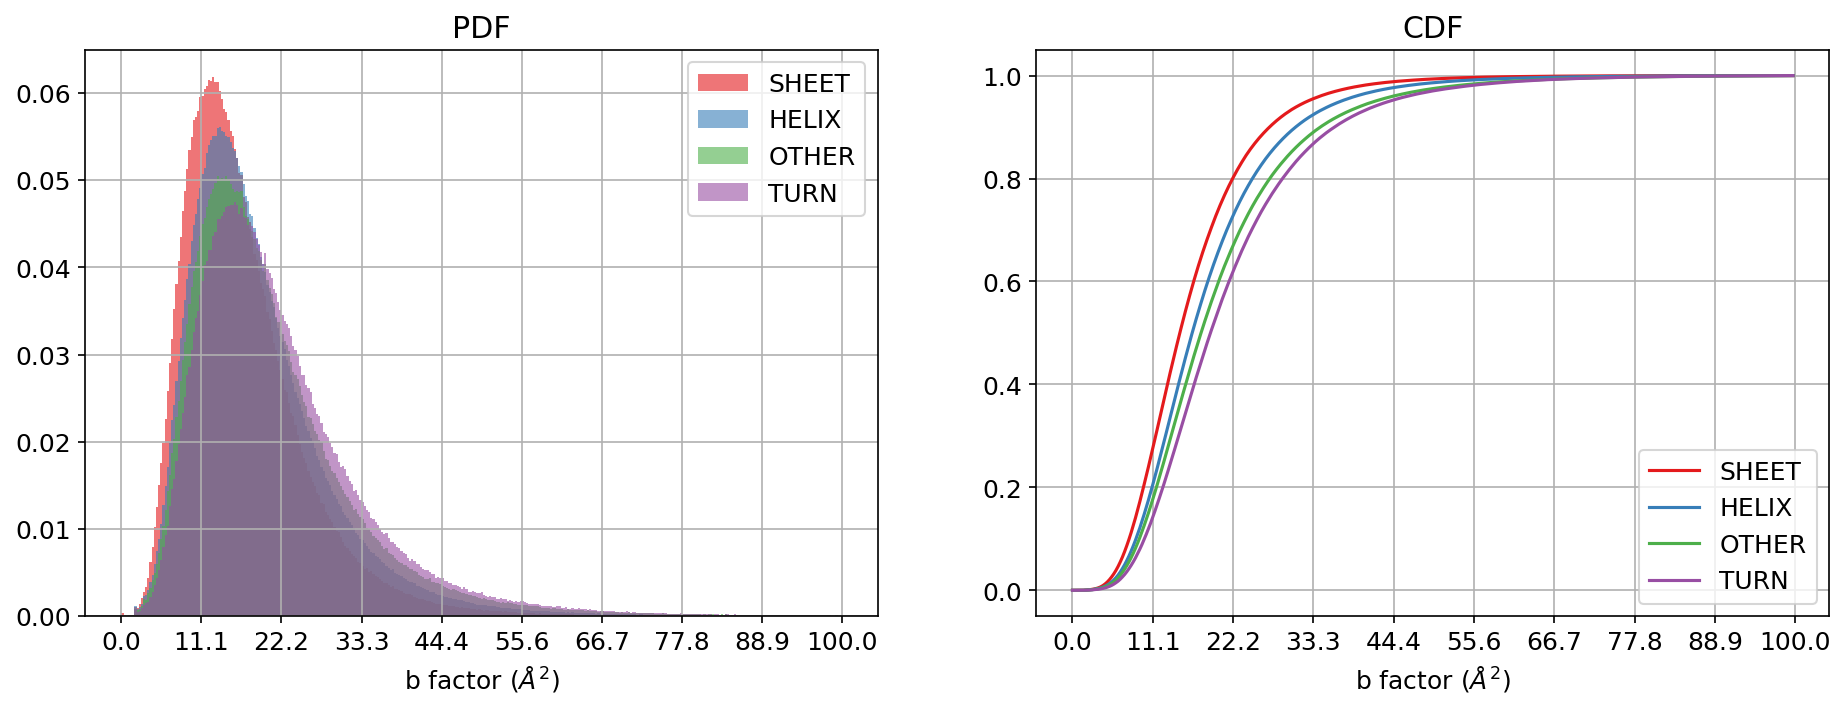

In [116]:
from typing import List


HIST_RANGE = np.array([0, 100])
N_BINS = 333
FIGS_DIR = pp5.out_subdir('figs')

with mpl.style.context('cfg/pp5_plotstyle.rc.ini'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for ss, bfactors in ss_bfactors.items():
    
        hist, bins = np.histogram(bfactors, bins=N_BINS, density=True, range=HIST_RANGE)
        delta = bins[1]-bins[0]
        print(ss, bins.shape, hist.shape, f'sum={np.trapz(hist, bins[:-1])}')
    
        a: plt.Axes = axes[0]
        a.bar(x=bins[:-1], height=hist, width=delta, align='edge', alpha=0.6, label=ss)
        a.set_title('PDF')

        a: plt.Axes = axes[1]
        a.plot(bins[:-1], np.cumsum(hist*delta), label=ss)
        a.set_title('CDF')

    for a in axes:
        a.set_xlabel('b factor ($\AA^2$)');
        a.set_xticks(np.linspace(HIST_RANGE[0], HIST_RANGE[1], num=10, endpoint=True))
        a.grid('on');
        a.legend();
        
    fig.savefig(FIGS_DIR.joinpath('bfactors_hist.pdf'))